# Final model

Ended up going with logistic regression, and found a way to include preprocessor in pipeline

In [1]:
import pandas as pd
import nltk

from sklearn.feature_extraction.text import TfidfVectorizer
# from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

from sklearn.feature_selection import chi2, SelectPercentile
from sklearn.pipeline import Pipeline

from preproc import Preproc

### Create pipeline

Hyperparameters were tuned quite extensively to find optimal values

In [2]:
sent_pipe = Pipeline([
    ("preprocessor", Preproc()),
    ("vectorizer"  , TfidfVectorizer(ngram_range=(1,3), min_df=6)),
    ("selector"    , SelectPercentile(score_func=chi2, percentile=26)),
    ("classifier"  , LogisticRegression(solver="liblinear", C=5))
])

### Get reviews on which to train model

In [3]:
reviews = pd.read_csv("Data/scraped_comments_with_professor.csv")

Basic preprocessing to ensure other steps don't break

In [4]:
reviews.drop_duplicates(subset="comment_id", keep="first", inplace=True)

reviews.dropna(subset=["comment"], inplace=True)            # drop comments that are empty or consist of "No Comments"
reviews = reviews[reviews["comment"] != "No Comments"]

reviews['firstName'].fillna('', inplace=True)               # drop reviews that don't have professor names (idk how they exist)
reviews['lastName'].fillna('', inplace=True)

reviews["comment"] = reviews["comment"].apply(lambda x: x if len(x.split()) > 5 else None)      # drop comments with less than 5 words
reviews.dropna(subset=["comment"], inplace=True)

Generate star rating as average of helpful and clarity ratings

In [5]:
reviews["starRating"] = (reviews["clarityRating"] + reviews["helpfulRating"]) / 2
reviews = reviews[reviews["starRating"] != 3.0]         # drop 3 star reviews (middling comments only confuse the model)
reviews.reset_index(drop=True, inplace=True)

reviews["starRating"].value_counts()

 5.0    176812
 4.5     58705
 4.0     52643
 1.0     45128
 2.0     26945
 3.5     22896
 1.5     19230
 2.5     17510
-1.0         1
Name: starRating, dtype: int64

Generate sentiment column according to star rating

In [9]:
reviews["sentiment"] = reviews["starRating"].apply(lambda x: 1 if x > 2.5 else 0)

### Fit model onto entire dataset read

No need to implement a train-test split, may as well train the model on as much data as possible

In [7]:
sent_pipe_fit = sent_pipe.fit(reviews, reviews["sentiment"])

In [8]:
from joblib import dump

dump(sent_pipe_fit, "final-LR-pipe.joblib")

['final-LR-pipe.joblib']

In [24]:
comm = "I had him for 222 and now 221. He is good, not great and not terrible. I like Kebo as a prof and how he makes the tests online and open note, it makes it less stressful. However I hate the homeworks and the way the TAs and the auto graders work. He doesnt do too hard of quizzes/tests which is awesome."
temp = pd.DataFrame(data={"firstName": ["David"], "lastName": ["Kebo"], "comment": comm})
temp.head()

,firstName,lastName,comment
0,David,Kebo,"I had him for 222 and now 221. He is good, not..."


In [25]:
sent_pipe_fit.predict(temp)

array([1], dtype=int64)

In [23]:
sent_pipe_fit.predict_proba(temp)

array([[0.13566143, 0.86433857]])

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

# %pip install wordcloud
from wordcloud import WordCloud

https://www.datacamp.com/tutorial/wordcloud-python

https://amueller.github.io/word_cloud/generated/wordcloud.WordCloud.html

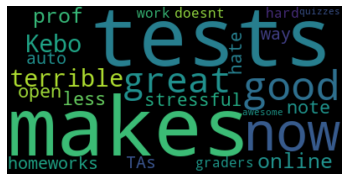

In [29]:
text = comm
wordcloud = WordCloud().generate(text)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [31]:
wordcloud.to_file("temp_review.png")